In [1]:
import sys 
sys.path.append('..')
from cox.utils import Parameters
from cox.store import Store
from cox.readers import CollectionReader
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import numpy as np
import torch as ch
from torch import Tensor
from torch.distributions.normal import Normal
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions import Uniform
from torch.utils.data import DataLoader
from delphi.stats.truncated_regression import truncated_regression
from delphi.utils.datasets import TruncatedRegressionDataset
from delphi.oracle import Left, Interval
import datetime

In [2]:
STORE_PATH = '/home/pstefanou/guess'
STORE_TABLE_NAME = 'guess'

store = Store(STORE_PATH)

store.add_table(STORE_TABLE_NAME, { 
    'known_param_mse': float,
    'unknown_param_mse': float, 
    'ols_param_mse': float,
    'alpha': float, 
    'var': float, 
})

Logging in: /home/pstefanou/guess/20d1e4bb-33df-4268-bf09-973841cdd3b6


In [47]:
# regression parameters
num_samples, dims = 100000, 1
phi = Left(Tensor([2.0]))
var = 1.0

# generate random uniform weights
W = ch.zeros(1, 1)
W0  = ch.zeros(1, 1)

# generate data
X = MultivariateNormal(ch.zeros(dims), ch.eye(dims)/dims).sample(ch.Size([num_samples]))
y = X.mm(W) + W0 + Normal(ch.zeros(1), ch.sqrt(Tensor([var]))).sample(ch.Size([num_samples]))
# truncate
indices = phi(y).nonzero(as_tuple=False).flatten()
y_trunc, x_trunc = y[indices], X[indices]

# empirical linear regression
reg = LinearRegression() 
reg.fit(x_trunc, y_trunc)
emp_var = ch.var(ch.from_numpy(reg.predict(x_trunc)) - y_trunc, dim=0).unsqueeze(0)

# experiment parameters
args = Parameters({ 
    'alpha': Tensor([y_trunc.size(0)/num_samples]), 
    'phi': phi, 
    'epochs': 10,
    'num_workers': 20, 
    'batch_size': 10,
    'bias': True,
    'num_samples': 100,
    'clamp': True, 
    'radius': 5.0, 
    'var_lr': 1e-2,
    'var': emp_var,
    'lr': 1e-1,
    'shuffle': True
})


# truncated linear regression with known noise variance - empirical estimate 
# dataset 
data = TruncatedRegressionDataset(x_trunc, y_trunc, bias=args.bias, unknown=False)
S = DataLoader(data, batch_size=args.batch_size, num_workers=args.num_workers, shuffle=args.shuffle)
trunc_reg = truncated_regression(phi=phi, alpha=args.alpha, epochs=args.epochs, lr=args.lr, num_samples=args.num_samples, var=args.var, device='cuda')
results = trunc_reg.fit(S)
w_, w0_ = results.weight.detach().cpu(), results.bias.detach().cpu()

# truncated linear regression with known noise variance - actual estimate
# dataset 
data = TruncatedRegressionDataset(x_trunc, y_trunc, bias=args.bias, unknown=False)
S = DataLoader(data, batch_size=args.batch_size, num_workers=args.num_workers, shuffle=args.shuffle)
trunc_reg = truncated_regression(phi=phi, alpha=args.alpha, epochs=args.epochs, lr=args.lr, num_samples=args.num_samples, var=var, device='cuda')
results = trunc_reg.fit(S)
w, w0 = results.weight.detach().cpu(), results.bias.detach().cpu()


# calculate metrics 
real_params = ch.cat([W, W0])
real_var_params = ch.cat([w, w0.unsqueeze(0)])
emp_var_params = ch.cat([w_.t(), w0_.unsqueeze(0)])

real_error = ch.abs((y_trunc - w.mm(x_trunc.T).T - w0).pow(2).mean(0) - var)
emp_var_error = ch.abs((y_trunc - w_.mm(x_trunc.T).T - w0_).pow(2).mean(0) - emp_var)


# store[STORE_TABLE_NAME].append_row({ 
#     'known_param_mse': known_param_mse,
#     'unknown_param_mse': unknown_param_mse,
#     'ols_param_mse': ols_param_mse,
#     'alpha': float(args.alpha.flatten()),
#     'var': float(var), 
# })

# close current store
store.close()

Epoch:1 | Loss 0.0530 | Train1 0.000 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 223/223 [00:06<00:00, 32.89it/s]
Epoch:2 | Loss 0.0602 | Train1 0.000 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 223/223 [00:06<00:00, 32.19it/s]
Epoch:3 | Loss 0.0635 | Train1 0.000 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 223/223 [00:06<00:00, 31.97it/s]
Epoch:4 | Loss 0.0624 | Train1 0.000 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 223/223 [00:07<00:00, 31.54it/s]
Epoch:5 | Loss 0.0625 | Train1 0.000 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 223/223 [00:07<00:00, 31.67it/s]
Epoch:6 | Loss 0.0626 | Train1 0.000 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 223/223 [00:06<00:00, 31.94it/s]
Epoch:7 | Loss 0.0625 | Train1 0.000 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 223/223 [00:06<00:00, 32.20it/s]
Epoch:8 | Loss 0.0625 | Train1 0.000 | Train5 -1.000 | Reg term: 0.0 ||: 100%|██████████| 223/223 [00:07<00:00, 31.68it/s]
Epoch:9 | Loss 0

In [48]:
print("real error: {}".format(real_error))
print("emp var error: {}".format(emp_var_error))

real error: tensor([3.1010])
emp var error: tensor([[0.0166]])


In [ ]:
print("lambda grad: {}".format(results.lambda_.grad))
print("bias grad: {}".format(results.bias.grad))
print("weight grad: {}".format(results.weight.grad))

In [ ]:
reader = CollectionReader(STORE_PATH)
results = reader.df(STORE_TABLE_NAME)
results.head()

In [13]:
known, unknown, ols = results[['known_param_mse', 'var']], results[['unknown_param_mse', 'var']], results[['ols_param_mse', 'var']]

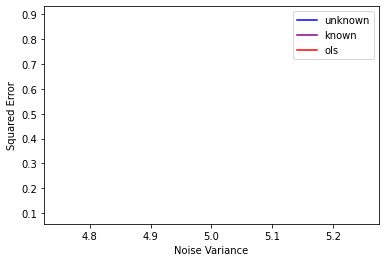

In [14]:
# plot results for regression parameter MSE
sns.lineplot(data=unknown, x='var', y='unknown_param_mse', label='unknown', color='blue')
sns.lineplot(data=known, x='var', y='known_param_mse', label='known', color='purple')
ax = sns.lineplot(data=ols, x='var', y='ols_param_mse', label='ols', color='red')
ax.set(xlabel='Noise Variance', ylabel='Squared Error')
plt.show()
# close reader
reader.close()

In [21]:
store.close()